<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Singular Spectrum Analysis with Pyleoclim

## Authors

Julien Emile-Geay Department of Earth Sciences, University of Southern California 

Author = {"name": "Julien Emile-Geay", "affiliation": "Department of Earth Sciences, University of Southern California", "email": "julieneg@usc.edu", "orcid": "0000-0001-5920-4751"}

## Preamble

It is common for climate scientists to borrow tools developed in other, more established disciplines. This is particularly so when it comes to timeseries analysis techniques, which have largely been developed by electrical engineers or financial mathematicians. Singular Spectrum Analysis (SSA) is the exception that confirms the rule. Introduced by [Vautard & Ghil, (1989)](https://www.sciencedirect.com/science/article/pii/016727899290103T), it is a method steeped in the theory of dynamical systems, designed specifically for the short and noisy timeseries that paleogeoscientists - particular, paleoclimatologists - love so. (yes, even if a record reaches back to the precambrian, it is "short" if the number of points is less than a few hundred samples). Unlike Fourier or wavelet analysis, and like principal component analysis, SSA extracts patterns of variations from the data themselves (using an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix)), then projects the data on these eigenvectors. In effect, SSA replaces Fourier's sines/cosines, or wavelet basis, by oscillations it pulls out of the data. The advantage is that those patterns came from the data, so they are (by construction) well suited to describing the data in question. The disadvantage is that some data must be sacrificed to find these patterns in the first place (unlike parametric methods like Fourier or wavelet analysis, where they are imposed). There is no free lunch! 

### Goals

- Learn the basics of SSA
- Learn how to apply SSA in `Pyleoclim`
- Use SSA for three applications: reconstruction, filtering, and imputation of missing values (interpolation). 

**Reading Time: 15 min**

### Keywords
Singular Spectral Analysis, Synthesis, Filtering, Imputation, Visualization 

### Pre-requisites
None

### Relevant Packages
pandas, matplotlib

## Data Description

Sea-surface temperature from [Kaplan (1998)](https://psl.noaa.gov/data/gridded/data.kaplan_sst.html) averaged over the NINO3 (5N-5S, 150W-190E)) region.   

## Code

Caveat emptor: like the vast majority of timeseries techniques, SSA assumes that the data are evenly-spaced. If you want to apply SSA to an unevenly-spaced series, you will need to cast it onto a regular time grid, using [NaNs](https://en.wikipedia.org/wiki/NaN) to signal missing values. `Pyleoclim`'s SSA implementation does allow modest amounts of missing values in the timeseries, though they should not be present in large contiguous blocks (see last section, below). 

We start by importing relevant packages, loading and plotting the timeseries of interest (NINO3). To simplify matters, let's standardize this timeseries (give it zero mean and unit standard deviation). 

In [1]:
import pyleoclim as pyleo
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

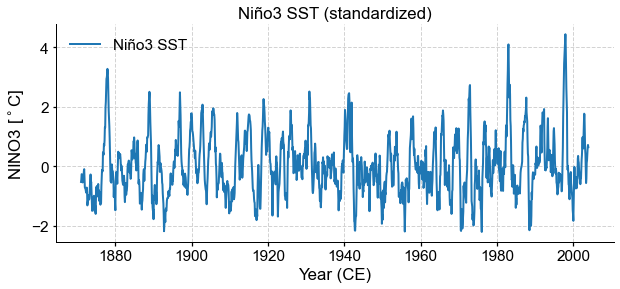

In [2]:
df = pd.read_csv('../data/wtc_test_data_nino_even.csv')

ts_nino = pyleo.Series(time = df['t'], value=df['nino'], 
                       time_name='Year (CE)', value_name='NINO3',
                       value_unit= '$^\circ$C', label='Niño3 SST')
  
ts_n    = ts_nino.standardize()
fig, ax = ts_n.plot(title= 'Niño3 SST (standardized)')

Let us now apply SSA to this series. While SSA is non-parametric, it does rely on one crucial parameter, the **embedding dimension**, denoted $M$, which describes the length of the time window over which SSA will hunt for oscillations. It has been shown that SSA can well identify oscillations with a period between $M/5$ and $M$.  By default, `pyleoclim` will use a value of 10% of the timeseries, in this case 159 months. In order to focus on interannual modes, let's use 60 months (5 years), in accord with [Ghil et al (2002)](https://doi.org/10.1029/2000RG000092).  

In [3]:
nino_ssa = ts_n.ssa(M = 60)

The output of this function is an [SsaRes](https://pyleoclim-util.readthedocs.io/en/master/core/api.html#ssares-pyleoclim-ssares) object, which includes a number of fields.

Let us now see how to make use of all these arrays. The first step is to inspect the eigenvalue spectrum ("[scree plot](https://en.wikipedia.org/wiki/Scree_plot)") to identify remarkable modes. 

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

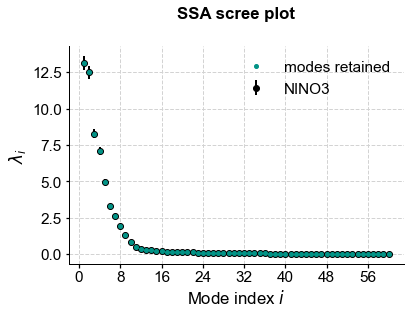

In [4]:
nino_ssa.screeplot()

This highlights a few common phenomena with SSA:
1. the eigenvalues are in descending order
1. their uncertainties are proportional to the eigenvalues themselves
1. the eigenvalues tend to come in pairs : (0,1) (2,3),  are all clustered within uncertainties.
1. around $i=15$, the eigenvalues appear to reach a floor, and all subsequent eigenvalues explain a very small amount of variance.

Indeed, the variance explained by mode $i$ is  $$ v_i = \frac{{\lambda_i}^2}{\sum_{k=0}^{M} {\lambda_k}^2} $$ where $\lambda_{i}$ the eigenvalue corresponding to mode $i$. So, summing the variance of all modes higher than 15, we get:

In [5]:
print(nino_ssa.pctvar[15:].sum()*100)

4.825612144779388


That is, over 95% of the variance is in the first 15 modes; almost all of it in the first 10 modes. That is a typical result for a "warm-colored" timeseries, which is most geophysical timeseries; a few modes do the vast majority of the work. That means we can focus our attention on these modes and capture most of the interesting behavior. To see this, let's use the reconstructed components (RCs), and sum the RC matrix over the first 10 columns:

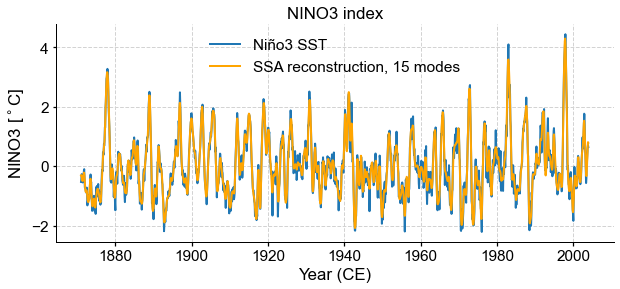

In [7]:
RCk = nino_ssa.RCmat[:,:15].sum(axis=1)
fig, ax = ts_n.plot(title='NINO3 index')
ax.plot(ts_n.time,RCk,label='SSA reconstruction, 15 modes',color='orange')
ax.legend()

Indeed, these first few modes capture the vast majority of the low-frequency behavior, including all the El Niño/La Niña events. What is left (the blue wiggles not captured in the orange curve) are high-frequency oscillations that might be considered "noise" from the standpoint of ENSO dynamics. This illustrates how SSA might be used for filtering a timeseries. One must be careful however: 

1. there was not much rhyme or reason for picking 15 modes. Why not 5, or 39? All we have seen so far is that they gather >95% of the variance, which is by no means a magic number.
1. there is no guarantee that the first few modes will filter out high-frequency behavior, or at what frequency cutoff they will do so. If you need to cut out specific frequencies, you are better off doing it with a classical filter (see `filtering_and_detrending.ipynb` tutorial). However, in many instances the choice of a cutoff frequency is itself rather arbitrary. In such cases, SSA provides a principled alternative for generating a version of a timeseries that preserves features and excludes others (i.e, a filter). 
1. as with all orthogonal decompositions, summing over all RCs will recover the original signal within numerical precision.


## Monte-Carlo SSA

Selecting meaningful modes in eigenproblems like SSA or PCA is more art than science. However, one technique stands out here: Monte Carlo SSA, introduced by [Allen & Smith, (1996)](https://doi.org/10.1175/1520-0442(1996)009%3C3373:MCSDIO%3E2.0.CO;2) to identiy SSA modes that rise above what one would expect from "red noise", specifically an [AR(1) process](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process). To run it, simply provide the parameter $MC$, ideally with a number of iterations sufficient to get decent statistics. Here's let's use $MC = 1000$. The result will be stored in the **eigvals_q** array, which has the same length as `eigvals`, and its two columns contain the 5% and 95% quantiles of the ensemble of MC-SSA eigenvalues. 

In [8]:
nino_mcssa = ts_n.ssa(M = 60, nMC=1000)

/Users/deborahkhider/opt/anaconda3/envs/paleodev/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now let's look at the result:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

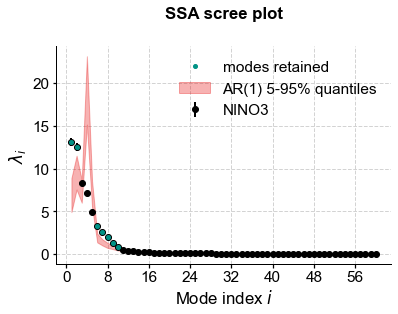

In [9]:
nino_mcssa.screeplot()

The `screeplot` method was able to make use of this new information and added a red noise background spectrum (in red, naturally). The plot suggests that modes 1, 2 and 6 to 10 fall above the red noise benchmark. More precisely, one may extract those modes using `mode_idx`:

In [10]:
nino_mcssa.mode_idx

array([0, 1, 5, 6, 7, 8, 9])


Pursuant to Python's 0-based indices, this vector of indices is 0-based. However, to conform to standard usage, the modes are referred to by their ordinal (i.e. index $i$ corresponds to mode $i+1$). 
Let us zoom in on those modes, and use them for pre-filtering prior to spectral analysis. 

## SSA pre-filtering

Let's first look at the spectrum of the raw index, using two  methods included in Pyleoclim: the Multi-Taper Method (MTM) and the Weighted Wavelet Z transform (WWZ). A tutorial on `pyleoclim`'s spectral methods may be found in the `spectral_analysis.ipynb` tutorial.

In [11]:
%matplotlib inline

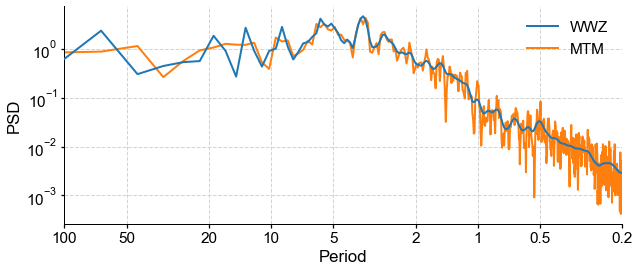

In [17]:
psd_mtm = ts_n.interp().spectral(method='mtm', settings={'NW': 2})
psd_wwz = ts_n.spectral(method='wwz', settings={'freq':psd_mtm.frequency})  # pass the frequency vector to compare apples to apples
fig, ax = psd_wwz.plot(label='WWZ', zorder=99)
ax = psd_mtm.plot(ax=ax, label='MTM')

Here we see clear interannual peaks, particular the [quasi-quadriennial](https://link.springer.com/article/10.1007/BF00223723) one (around 4 years, as the name implies). MTM with default parameters smoothes out the decadal-to-centennial part of the spectrum, but produces a lot of peaks at periods shorter than 2 years.  In contrast, WWZ smoothes out these high-frequency features, but shows peaks in the decadal range that MTM, certainly, does not see. Would pre-filtering NINO3 using the most robust SSA modes help with that? Also, are each of the interannual peaks carried by individual oscillations that a linear method like SSA could separate?

To answer these questions, let's inspect those key modes with the `modeplot` function, which shows the corresponding T-EOF, RC, and spectra. First, mode 1 (remember that index = mode - 1).

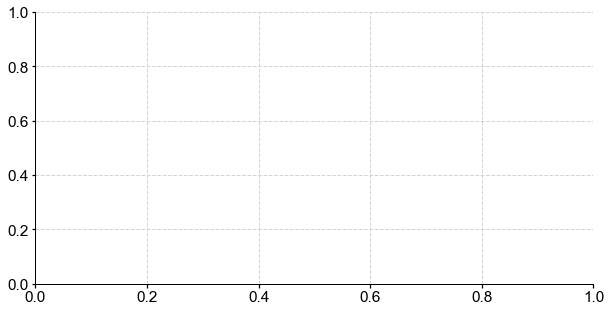

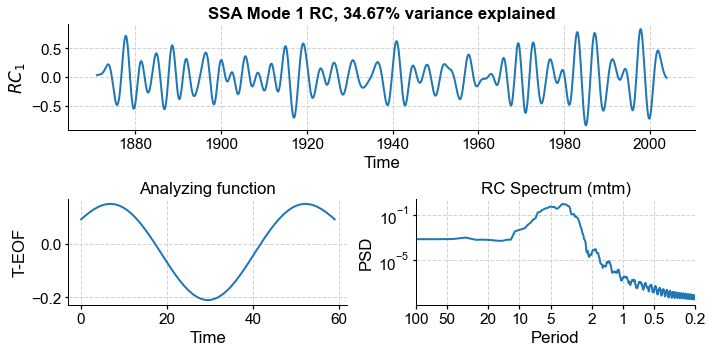

In [18]:
fig,ax=nino_mcssa.modeplot(index=0)

This first mode, with nearly 35% of the variance, is associated with a nearly pure sinusoid with a period near 48 months. The two peaks near 0.2 years are strange, and in need of an explanation.  Now mode 2:

(<Figure size 720x360 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

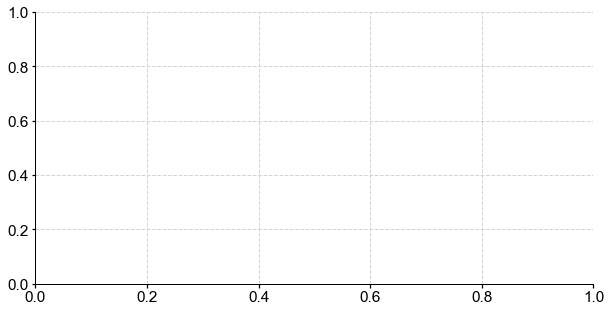

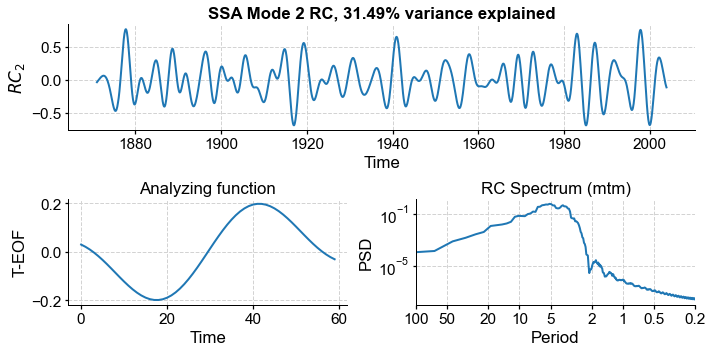

In [19]:
nino_mcssa.modeplot(index=1)

Mode 2 has a nearly similar spectral signature as mode 1, consistent with those two modes being part of a pair. Its T-EOF is (by construction) orthogonal to that of mode 1, and one may think of them as a sine/cosine pair for this particular oscillation around 4 years. Together, they account for about 2/3 of the total variance.  What about modes 6 to 9?

(<Figure size 720x360 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

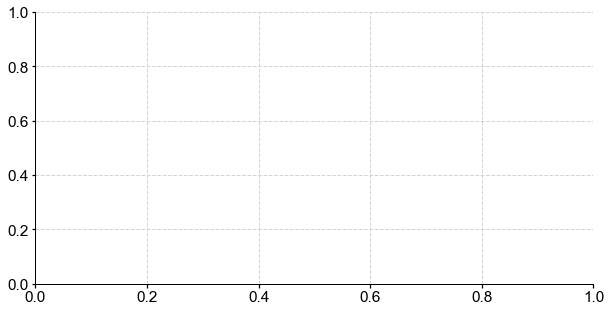

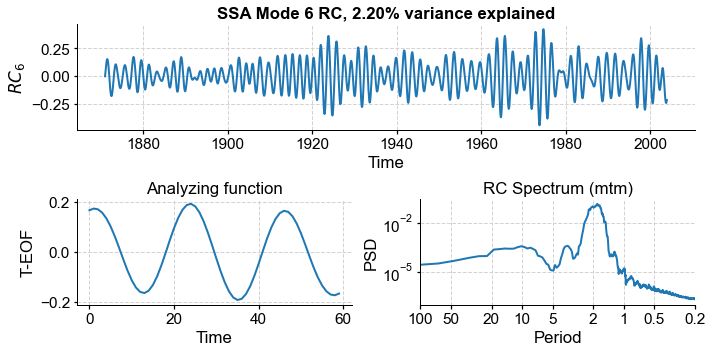

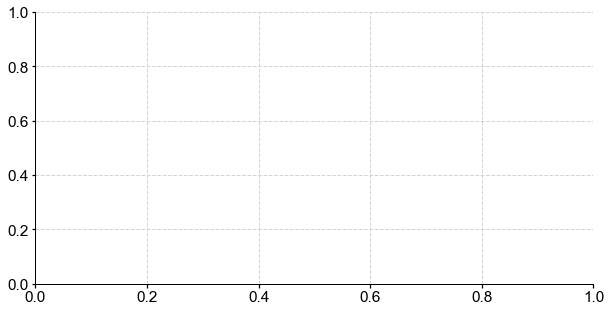

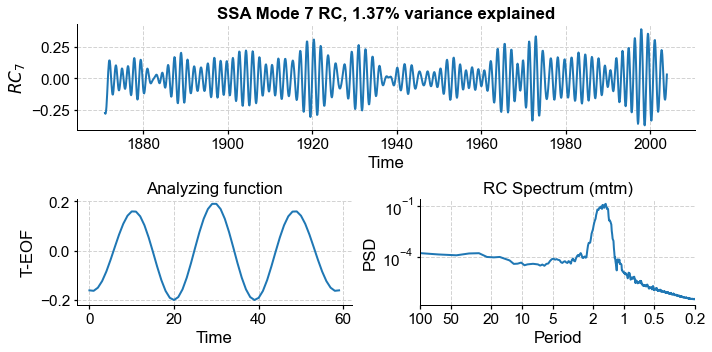

In [20]:
nino_mcssa.modeplot(index=5)
nino_mcssa.modeplot(index=6)

Modes 6 and 7 are associated with oscillations around 2 years, though the peaks are again fairly broad, indicative of low-frequency modulation (as evidenced in the envelope of these ~2y cycles). To refine the spectral estimate for these features, one could:
1. play with the time-bandwidth product ($N_W$) of MTM.
1. apply other techniques better suited to detecting narrow-band peaks (e.g. Burg's method).  
1. apply yet other methods suited for nonlinear and non-stationary signals, like the Hilbert-Huang Transform.

Such is not our purpose, so we move instead to prefiltering using the modes identified above.

Finally, modes 8 and 9:

(<Figure size 720x360 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

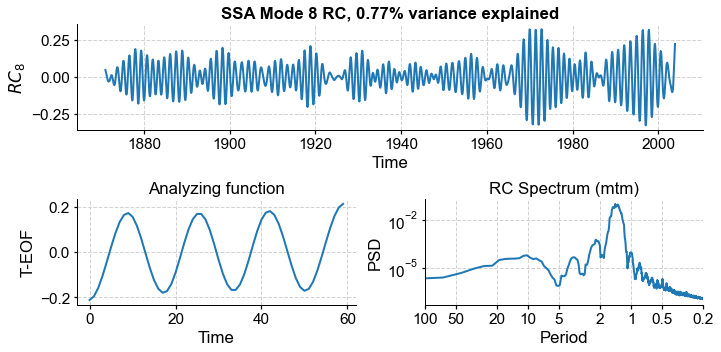

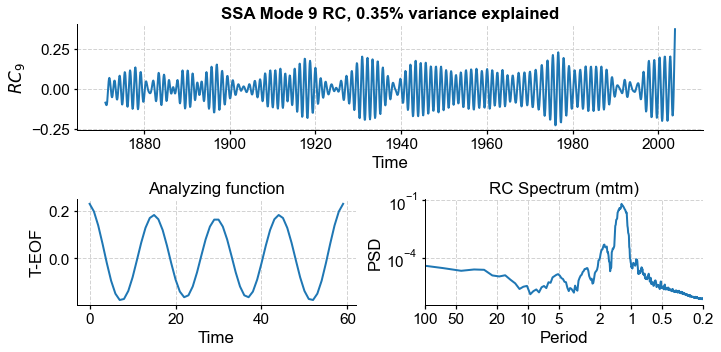

In [17]:
nino_mcssa.modeplot(index=7)
nino_mcssa.modeplot(index=8)

Those also have a nearly harmonic (sinusoidal) structure, with a shorter period between 1 and 2 years. Again, they seem to form a pair.  Overall, we see that, as we go up the ranks, the period of oscillation diminishes, as does the variance (by construction). That is again a common property of geophysical timeseries, which tend to be "warm colored" (more spectral energy at lower frequencies).

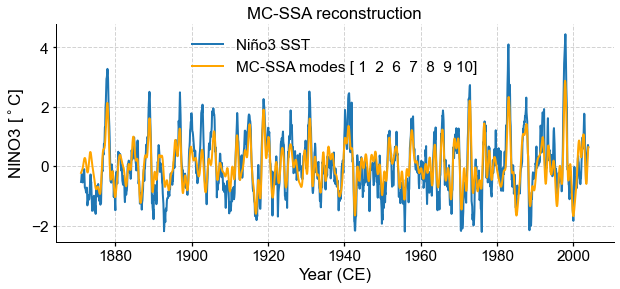

In [18]:
fig, ax = ts_n.plot(title='MC-SSA reconstruction') # we mute the first call to only get the plot with 2 lines
ax.plot(ts_n.time,nino_mcssa.RCseries,label='MC-SSA modes '+str(nino_mcssa.mode_idx+1),color='orange')
ax.legend()

What was in the modes excluded by MC-SSA, you ask? Let's have a look.

(<Figure size 720x360 with 3 Axes>,
 <AxesSubplot:title={'center':'RC Spectrum (mtm)'}, xlabel='Period', ylabel='PSD'>)

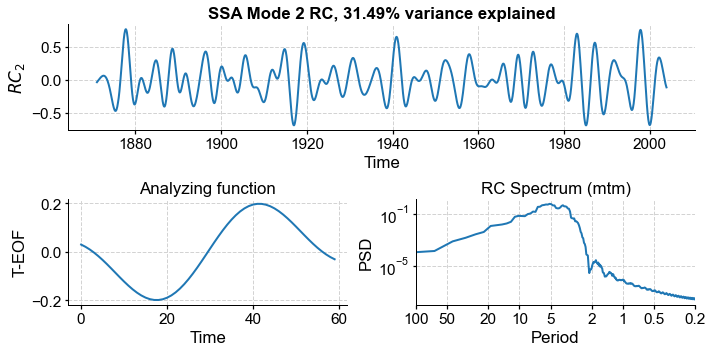

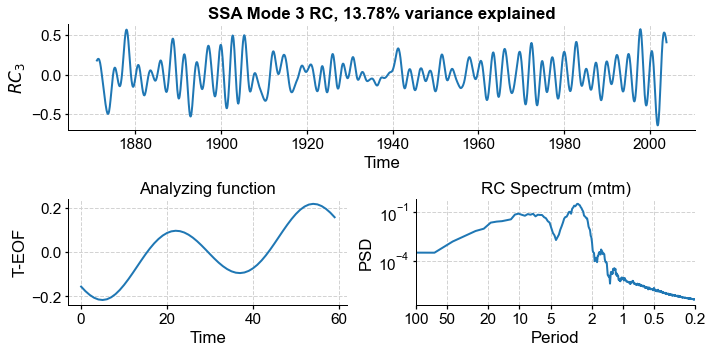

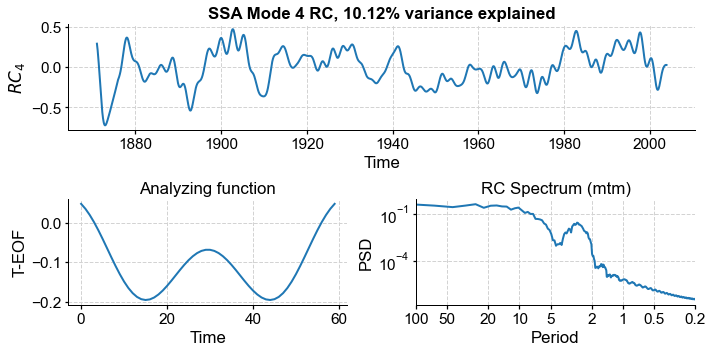

In [19]:
nino_mcssa.modeplot(index=1)
nino_mcssa.modeplot(index=2)
nino_mcssa.modeplot(index=3)

Those modes contained a lot of low-frequency signals (compare their spectra to those of the other modes), some associated with trends in variance. However, MC-SSA found that these signals do not stand out compared to red noise, so it left them out. Note that with different choices of embedding dimension ($M$), different modes will capture different features.

However, it is generally true over a broad range of choices that the MC-SSA modes capture most of the features of interest, including the various ENSO events. Let us now perform spectral analysis on a version of the timeseries that includes only those modes: 

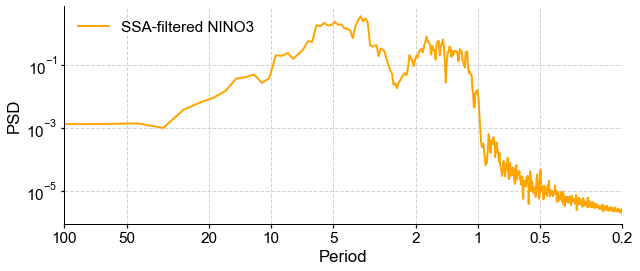

In [20]:
ts_rc = pyleo.Series(time=ts_n.time, value=nino_mcssa.RCseries) # create timeseries object 
psd_mtm = ts_rc.interp().spectral(method='mtm', settings={'NW': 2}) # apply MTM spectral analysis
fig, ax = psd_mtm.plot(label='SSA-filtered NINO3', color='orange') # plot it

We see indeed the variance concentrated in the interannual range, 1 to 8 years. The signal is overall much cleaner than before, illustrating the beneficial effects of SSA to filter signals of interest prior to applying spectral analysis. 


## SSA with missing values

A useful feature of the `pyleoclim` implementation of SSA is the ability to deal with missing values, which is particularly critical in the paleosciences, where data are seldom sampled at regular time intervals. 
It turns out that SSA can also be applied on timeseries that contain a reasonable amount of missing data, thanks to the work of [Schoellhamer (2001)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2000GL012698). To illustrate this, we simply dig some holes in the NINO3 series, apply SSA, and compare the results for various fractions of missing values. 

In [21]:
t = ts_n.time
n = len(t)
fm = 0.1  #fraction of missing values
missing = np.random.choice(n,np.floor(fm*n).astype('int'),replace=False)

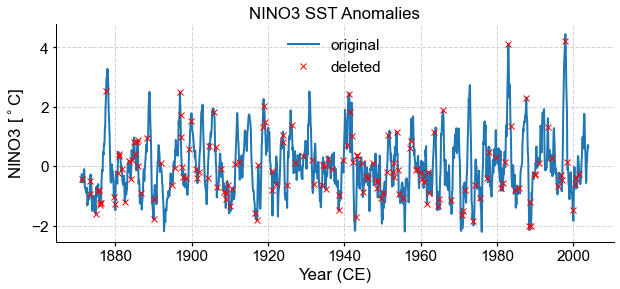

In [23]:
fig, ax = ts_n.plot(title='NINO3 SST Anomalies',label='original')
ax.plot(t[missing],ts_n.value[missing],'rx',label='deleted')
ax.legend()

Now let's apply SSA to the incomplete data (blue minus red)

In [24]:
nino_miss = np.copy(ts_n.value)
nino_miss[missing] = np.nan  # put NaNs at the randomly chosen locations
ts_miss = pyleo.Series(time=t,value=nino_miss, clean_ts=False)
miss_ssa = ts_miss.ssa(M = 60, trunc='var',var_thresh=95)

<AxesSubplot:title={'center':'NINO3 index'}, xlabel='time', ylabel='value'>

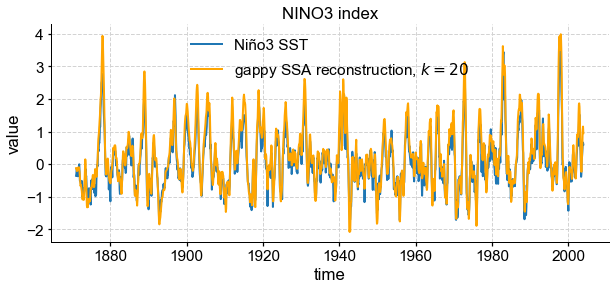

In [31]:
RCmiss = miss_ssa.RCmat[:,:19].sum(axis=1)
RCmiss_series = pyleo.Series(t,RCmiss)
fig, ax = ts_nino.plot(title='NINO3 index') # we mute the first call to only get the plot with 2 lines
RCmiss_series.plot(ax=ax,label=f'gappy SSA reconstruction, $k=20$',color='orange')

We see that, despite missing 10% of the values, a low-order (20 mode) SSA synthesis is able to successfully capture the behavior of the original timeseries, much as it did before. Two questions: what happens if we use more or fewer modes? And what would happen with larger fractions of missing values? Let's find out.

First, we truncate the SSA expansion so it includes only modes that include 95% of the variance. This is set with `trunc='var',var_thresh=95` above, and the result is:

<AxesSubplot:title={'center':'NINO3 index'}, xlabel='time', ylabel='value'>

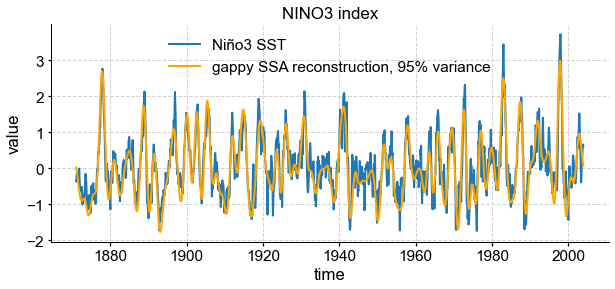

In [32]:
RCmiss = miss_ssa.RCseries
RCmiss_series = pyleo.Series(t,RCmiss)
fig, ax = ts_nino.plot(title='NINO3 index') # we mute the first call to only get the plot with 2 lines
RCmiss_series.plot(ax=ax,label=r'gappy SSA reconstruction, 95% variance',color='orange')

The series is a little smoother, which may not be a bad thing if you suspect there is some noise in your series. If not, you may decide to keep those 20 modes, and see what happens as the data become sparser: 

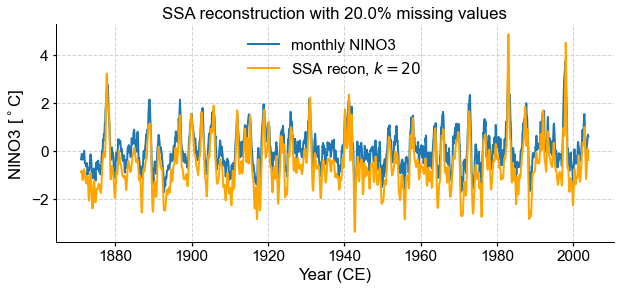

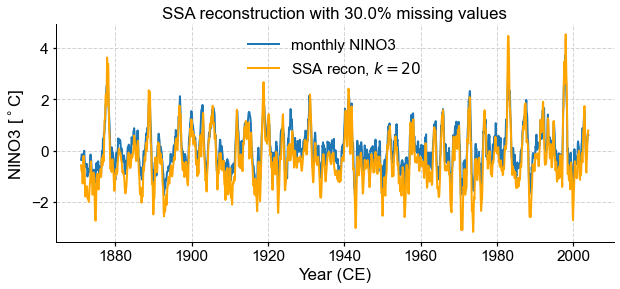

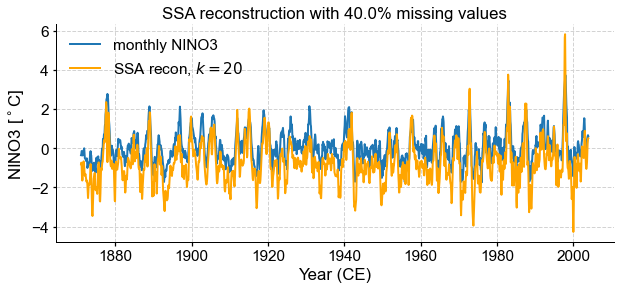

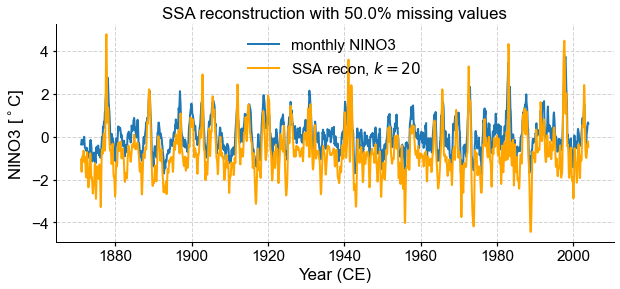

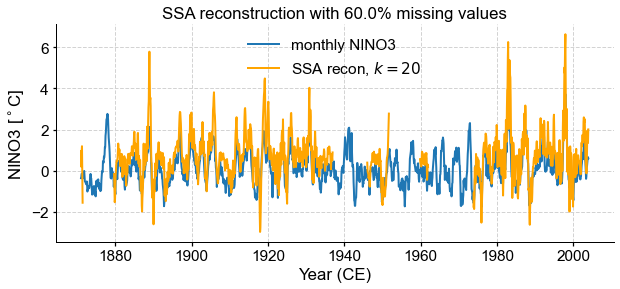

In [33]:
fmiss = [.2, .3, .4, .5, .6]

for fm in fmiss:
    missing = np.random.choice(n,np.floor(fm*n).astype('int'),replace=False)
    nino_miss = np.copy(ts_n.value)
    nino_miss[missing] = np.nan
    ts_miss = pyleo.Series(time=t,value=nino_miss, clean_ts=False)
    miss_ssa = ts_miss.ssa(M = 60)
    RCmiss = miss_ssa.RCmat[:,:19].sum(axis=1)
    fig, ax = ts_nino.plot(title=r'SSA reconstruction with '+ str(fm*100) +'% missing values',label='monthly NINO3')
    ax.plot(t,RCmiss,label='SSA recon, $k=20$',color='orange')
    ax.legend()

We see that SSA still does a respectable job with only half the points ($f = .50$), however the reconstruction degrades very quickly above that. It's already shabby at 60%, and more would be an unpleasant sight. Obviously, trying to reconstruct such a complex signal based on fewer samples than that is asking for trouble. In fact, it's already rather impressive that SSA can extract so much information from so few data. That is a testimony to the idea that most communication is [redundant](https://en.wikipedia.org/wiki/Information_theory), which is the basis of compression,  used so ubiquitously in the digital world (think mp3 audio files, jpeg photographs, etc). You may in fact think of this SSA reconstruction as a form of data compression. 

Now, this data compression is a lot easier when the data are missing at random, as was the case here. If we were to take out a contiguous chunk of the data , things would go sour very fast. Let's see that by taking out the second quarter of the series:

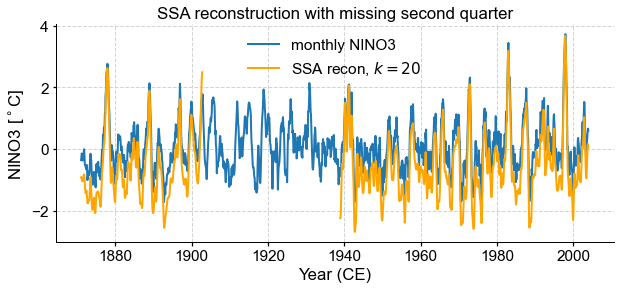

In [34]:
missing = np.arange(np.floor(n/4),np.floor(n/2),dtype='int')
nino_miss = np.copy(ts_n.value)
nino_miss[missing] = np.nan
ts_miss = pyleo.Series(time=t,value=nino_miss,clean_ts=False)
miss_ssa = ts_miss.ssa(M = 60)
RCmiss = miss_ssa.RCmat[:,:19].sum(axis=1)
fig, ax = ts_nino.plot(title=r'SSA reconstruction with missing second quarter',label='monthly NINO3')
ax.plot(t,RCmiss,label='SSA recon, $k=20$',color='orange')
ax.legend()

Here, the missing 25% could not be inferred, so SSA simply it left it out.  

In summary, SSA may be used for **interpolation** (that is, the **imputation of missing values**): instead of traditional methods like polynomial interpolation, it provides an alternative that leverages the underlying oscillatory components of the timeseries. However, the method canmot perform miracles, and works best when data are missing in non-contiguous blocks. At present, it does not provide error estimates around interpolated values, though one could imagine generalizations that do. Methods such as [these](https://onlinelibrary.wiley.com/doi/full/10.1002/cmm4.1080) might be helpful. 

## SSA approximation
Like all decomposition methods, SSA may be used to obtain approximations to the original data, often with the idea of filtering out noise. We've already seen how Monte Carlo SSA can be used for selecting modes that stand out against an AR(1) null. `Pyleoclim` also implements two simpler (and computationally light) options: the Kaiser rule, and a criterion on retained variance, which we used just above (the amount of variance retained is dictated by the parameter `var_thresh`).  The Kaiser rule (sometimes called Kaiser-Guttman rule) asserts that the modes that matter are those whose eigenvalue is above the mean (or median) of the eigenvalues.  Let us compare these three criteria:

In [35]:
kaiser = ts_n.ssa(M = 60, trunc = 'kaiser')
mc_ssa = ts_n.ssa(M = 60, trunc = 'mcssa',nMC=400)
var    = ts_n.ssa(M = 60, trunc = 'var', var_thresh=95)

The reconstructed series is stashed away into the `RCseries` variable; let us look at what that yields for each of these truncation methods:

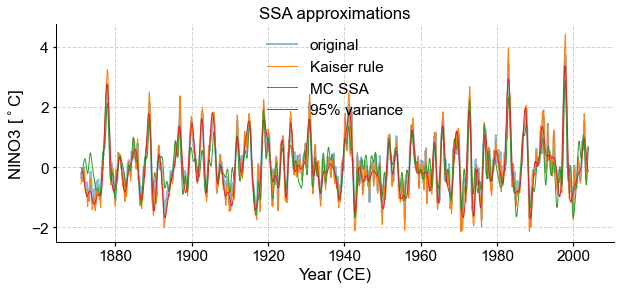

In [36]:
fig, ax = ts_nino.plot(title=r'SSA approximations',label='original',alpha=0.5)
alp=1
ax.plot(t,kaiser.RCseries,label='Kaiser rule',alpha=alp,lw=1)
ax.plot(t,mc_ssa.RCseries,label='MC SSA',alpha=alp,lw=1)
ax.plot(t,var.RCseries,label='95% variance',alpha=alp,lw=1)

ax.legend()

One can see that the various methods come out with comparable approximations to the original series, all tending to smooth out high-frequency oscillations. One caveat is that such approximations do not preserve  variance, so this should be kept in mind in case variance matters to your analysis. The variance threshold is arbitrary, making it hard to justify, and the Kaiser-Guttman rule is not rooted in much theory, though it works reasonably in practice. 

There would be other truncation criteria, like Equation 26 in [Nadakuditi & Edelman (2008)](https://doi.org/10.1109/TSP.2008.917356), which have yet to be implemented.